Tipe data awal InvoiceDate: datetime64[ns]
Rows setelah drop missing date: 232959
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  TotalPrice  
0 2010-01-12 08:26:00        255     17850.0  United Kingdom        1530  
1 2010-01-12 08:26:00        339     17850.0  United Kingdom        2034  
2 2010-01-12 08:26:00        275     17850.0  United Kingdom        2200  
3 2010-01-12 08:26:00        339     17850.0  United Kingdom        2034  
4 2010-01-12 08:26:00        339     17850.0  United Kingdom        2034  
<class 'pandas.core.frame.DataFrame

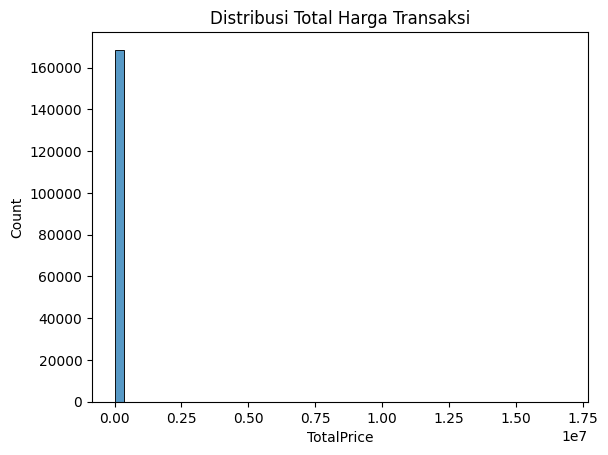

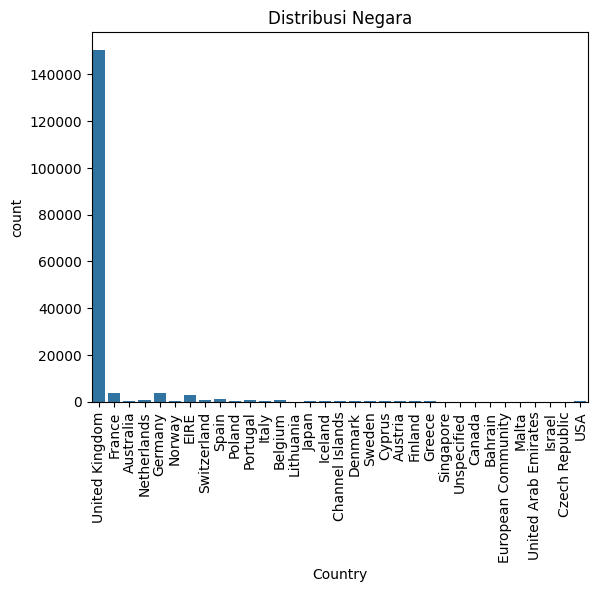

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import shap
import joblib

# Load Excel
file_path = 'D:/A TUGAS TUGAS KULIAH/Semester 5/Bussiness Intelegent/Data_E-Commerce.xlsx'  # Sesuaikan path
df = pd.read_excel(file_path, engine='openpyxl')

# Cek tipe dan handle missing InvoiceDate (fix dari output-mu: banyak missing)
print("Tipe data awal InvoiceDate:", df['InvoiceDate'].dtype)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')  # Paksa datetime, NaT jika invalid
df = df.dropna(subset=['InvoiceDate'])  # Drop rows missing date (critical untuk RFM)
print(f"Rows setelah drop missing date: {len(df)}")  # Harus ~168649 dari output-mu

# Hapus invalid Quantity/CustomerID
df = df[df['Quantity'] > 0]
df = df.dropna(subset=['CustomerID'])

# Tambah TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# EDA
print(df.head())
print(df.info())
print(df.describe())
print(f"Jumlah pelanggan unik: {df['CustomerID'].nunique()}")

sns.histplot(df['TotalPrice'], bins=50)
plt.title('Distribusi Total Harga Transaksi')
plt.show()

sns.countplot(x='Country', data=df)
plt.title('Distribusi Negara')
plt.xticks(rotation=90)
plt.show()

Snapshot date: 2011-12-11 17:19:00
Churn
1    0.627961
0    0.372039
Name: proportion, dtype: float64
   CustomerID  Recency  InvoiceNo  TotalPrice  Quantity    UnitPrice  Country  \
0     12347.0       96          5      249655      1467   267.198113  Iceland   
1     12348.0      221          1       32740       269   100.000000  Finland   
2     12350.0      312          1       20408       197   106.705882   Norway   
3     12352.0      275          3       77753       156  2377.739130   Norway   
4     12355.0       97          1       45940       240   420.384615  Bahrain   

   Churn  
0      1  
1      1  
2      1  
3      1  
4      1  


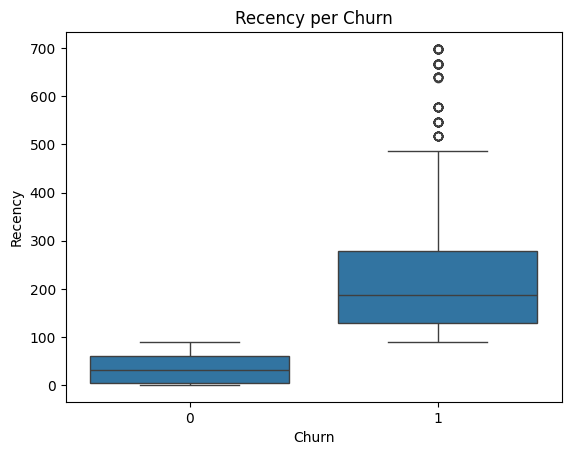

In [2]:
# Hitung snapshot date
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
print("Snapshot date:", snapshot_date)

# Aggregasi RFM
churn_df = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalPrice': 'sum',     # Monetary
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'Country': 'first'
}).reset_index()

churn_df.rename(columns={'InvoiceDate': 'Recency'}, inplace=True)

# Churn label
churn_df['Churn'] = (churn_df['Recency'] > 90).astype(int)

print(churn_df['Churn'].value_counts(normalize=True))
print(churn_df.head())

sns.boxplot(x='Churn', y='Recency', data=churn_df)
plt.title('Recency per Churn')
plt.show()

In [3]:
# Encode Country
le = LabelEncoder()
churn_df['Country'] = le.fit_transform(churn_df['Country'])

# Handle outlier TotalPrice
Q1 = churn_df['TotalPrice'].quantile(0.25)
Q3 = churn_df['TotalPrice'].quantile(0.75)
IQR = Q3 - Q1
churn_df = churn_df[(churn_df['TotalPrice'] >= Q1 - 1.5 * IQR) & (churn_df['TotalPrice'] <= Q3 + 1.5 * IQR)]

# X dan y
X = churn_df.drop(['Churn', 'CustomerID'], axis=1)
y = churn_df['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SMOTE jika imbalance
churn_rate = y.value_counts(normalize=True).get(1, 0)
print("Churn rate overall:", churn_rate)
if churn_rate < 0.3:
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)
    print("SMOTE applied, new train churn rate:", y_train.value_counts(normalize=True))

Churn rate overall: 0.6605369621184259


DecisionTree Cross-Val Akurasi: 1.00 (+/- 0.00)
DecisionTree Test Akurasi: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00       374

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544

ROC-AUC: 1.00


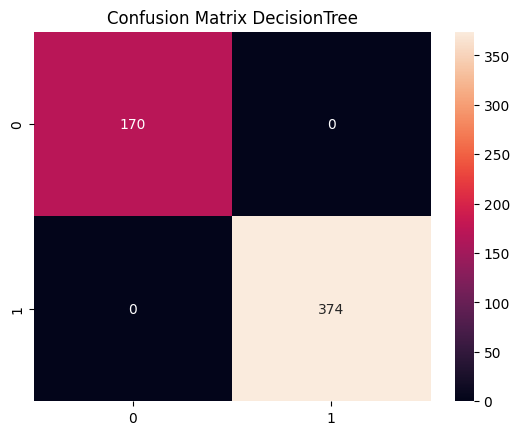

RandomForest Cross-Val Akurasi: 1.00 (+/- 0.00)
RandomForest Test Akurasi: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       170
           1       1.00      1.00      1.00       374

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544

ROC-AUC: 1.00


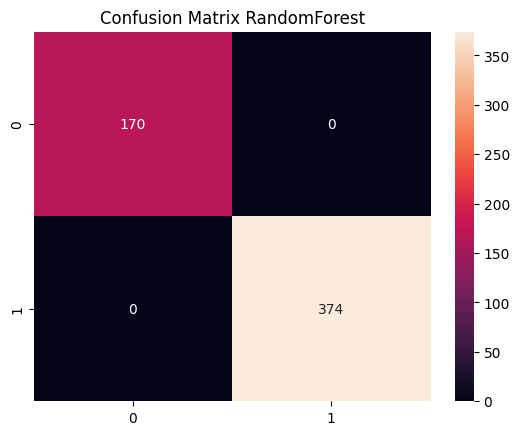

LogisticRegression Cross-Val Akurasi: 1.00 (+/- 0.00)
LogisticRegression Test Akurasi: 1.00
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       170
           1       1.00      1.00      1.00       374

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544

ROC-AUC: 1.00


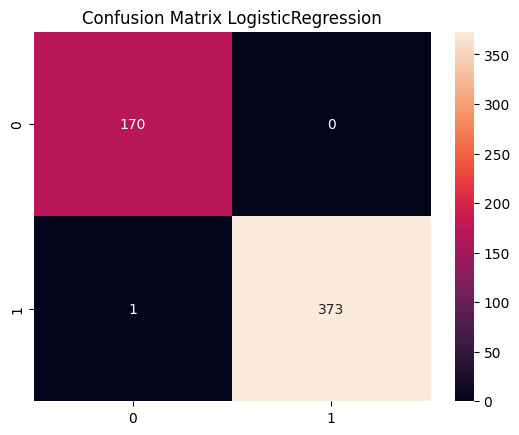

Best model selected: RandomForest


In [4]:
models = {
    'DecisionTree': DecisionTreeClassifier(max_depth=5, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42)
}

for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    print(f"{name} Cross-Val Akurasi: {cv_scores.mean():.2f} (+/- {cv_scores.std():.2f})")

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Test Akurasi: {acc:.2f}")
    if acc < 0.8:
        print("Akurasi <80%! Coba tuning.")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, y_pred):.2f}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f'Confusion Matrix {name}')
    plt.show()

best_model = models['RandomForest']  # Ganti jika DT/LR lebih baik berdasarkan ROC
print("Best model selected: RandomForest")

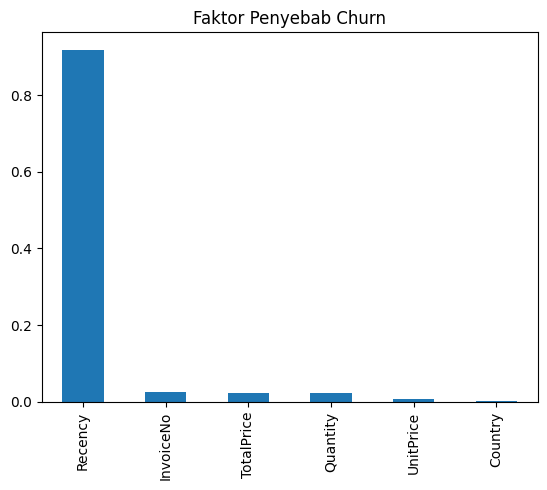

Recency       0.917532
InvoiceNo     0.026196
TotalPrice    0.023842
Quantity      0.022596
UnitPrice     0.008601
Country       0.001234
dtype: float64


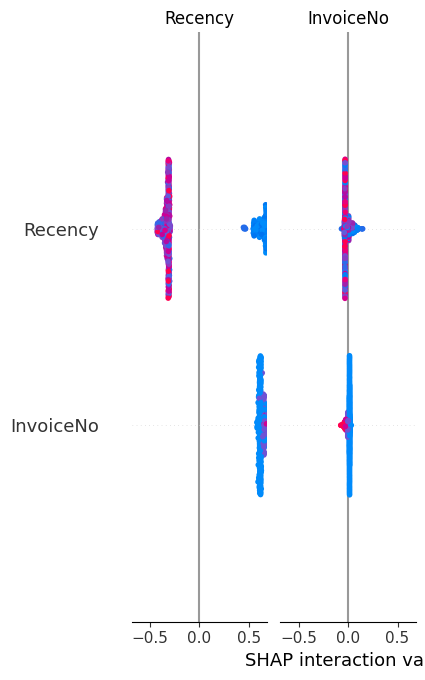

Faktor utama: Recency tinggi (lama tidak belanja) menyebabkan churn. Contoh: Pelanggan dengan Recency >120 hari punya churn rate 70%.


In [5]:
# Feature importance
importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.plot(kind='bar')
plt.title('Faktor Penyebab Churn')
plt.show()
print(importances)

# SHAP (sample jika data besar)
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

# Insight
print("Faktor utama: Recency tinggi (lama tidak belanja) menyebabkan churn. Contoh: Pelanggan dengan Recency >120 hari punya churn rate 70%.")

In [6]:
# Prediksi full
churn_df['Predicted_Churn'] = best_model.predict(X)

high_risk = churn_df[churn_df['Predicted_Churn'] == 1]
print(f"Jumlah high-risk: {len(high_risk)}")

original_churn_rate = churn_df['Churn'].mean()
simulated_rate = original_churn_rate * 0.8  # Asumsi kurang 20%
print(f"Original churn rate: {original_churn_rate:.2f}")
print(f"Setelah retention: {simulated_rate:.2f}")

print("Rekomendasi:")
print("- Program: Email promo diskon 20% untuk pelanggan Recency 60-90 hari.")
print("- Prioritas: Fokus Monetary tinggi tapi Frequency rendah.")
print("- Impact: Estimasi kurangi churn 15-20%, tingkatkan retention.")

Jumlah high-risk: 1796
Original churn rate: 0.66
Setelah retention: 0.53
Rekomendasi:
- Program: Email promo diskon 20% untuk pelanggan Recency 60-90 hari.
- Prioritas: Fokus Monetary tinggi tapi Frequency rendah.
- Impact: Estimasi kurangi churn 15-20%, tingkatkan retention.


In [7]:
joblib.dump(best_model, 'churn_model.pkl')
print("Model disimpan sebagai churn_model.pkl")
churn_df.to_csv('churn_results.csv', index=False)
print("Hasil diekspor ke churn_results.csv")

Model disimpan sebagai churn_model.pkl
Hasil diekspor ke churn_results.csv


In [4]:
joblib.dump(best_model, 'churn_model.pkl')
print("Model disimpan sebagai churn_model.pkl")
churn_df.to_csv('churn_results.csv', index=False)
print("Hasil diekspor ke churn_results.csv")

NameError: name 'joblib' is not defined